In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from params import *
import tqdm
import ghibtools as gh
import seaborn as sns
import pingouin as pg
%matplotlib inline

## TOOLS

APPROCHE PHASE

In [3]:
def load_resp(patient):
    rsp = pd.read_excel(f'../df_analyse/resp_features_{patient}.xlsx', index_col = 0)
    return rsp

In [4]:
def load_sp(patient):
    spindles = pd.read_excel(f'../df_analyse/spindles_{patient}.xlsx', index_col = 0)
    return spindles

In [5]:
def load_sw(patient):
    sw = pd.read_excel(f'../df_analyse/sw_{patient}.xlsx', index_col = 0)
    return sw

In [6]:
def count_events_phase_resp(nbins, patient, events, rsp_events, return_normal=True, save_rsp_encoded=False):
    
    rsp_cycles_with_event = []
    
    count = []

    for cycle in rsp_events.index: # loop only on cycles with spindles found inside
        
        start = rsp_events.loc[cycle,'inspi_time'] # get start time of the cycle
        stop = start + rsp_events.loc[cycle,'cycle_duration'] # get stop time of the cycle

        phases_timings = np.linspace(start, stop, nbins + 1) # slice the cycle time in n equal phase time points
        
        events_of_the_cycle = events[(events >= start) & (events <= stop)].values # keep the spindles of the cycle
        
        if events_of_the_cycle.shape[0] != 0:
            rsp_cycles_with_event.append(1)
        else:
            rsp_cycles_with_event.append(0)
        
        for event_time in events_of_the_cycle: # loop on spindles of the cycle
            for phase_bin, phase_start in enumerate(phases_timings): # loop on phases start times and attribute bin value to the phase
                if phase_start == phases_timings[-1]: # trick to stop looping if phase start == last phase timing
                    break 
                else:
                    phase_stop = phases_timings[phase_bin + 1] # stop time of this phase bin = next phase timing after the start phase timing of the list
                    if event_time >= phase_start and event_time < phase_stop: # if there is a spindle found between start and stop timings of the phase..
                        count.append(phase_bin) # ..the bin value is added to a counter

    if not return_normal: # return raw counts of spindles by bins
        phase_count = pd.Series(count).value_counts(normalize = False).reindex(np.arange(0,nbins))
        phase_count = phase_count.to_frame().T
    else: # return normalized counts of spindles by bins (each bin value = bin value / sum of all bin values) = default mode
        phase_count = pd.Series(count).value_counts(normalize = True).reindex(np.arange(0,nbins))
        phase_count = phase_count.to_frame().T
        mi = gh.Modulation_Index(phase_count.values)
        phase_count.insert(0 , 'mi', mi)

    phase_count.insert(0 , 'patient', patient)
    
    if save_rsp_encoded:
        if len(rsp_cycles_with_event) == rsp_events.shape[0]:
            rsp_events['event'] = rsp_cycles_with_event
            rsp_events.to_excel(f'../df_analyse/resp_features_encoded_{patient}.xlsx')
        else:
            assert ValueError('cycles encoded size different than rsp features size')
        
    return phase_count

In [7]:
def to_tidy(df):
    patients = df['patient'].values
    df = df.set_index('patient')
    rows = []
    for patient in patients:
        mi = df.loc[patient,'mi']
        phases = [col for col in df.columns if not col == 'mi']
        for phase in phases:
            phase_value = df.loc[patient,phase]
            rows.append([patient, mi , phase, phase_value])
    return pd.DataFrame(rows, columns = ['patient','mi','phase','bin value'])

## GO

In [8]:
save = False

concat_sp_phasing = []
concat_sw_phasing = []

nbins = 18

for patient in patients:
    print(patient)
    rsp = load_resp(patient)
    
    sp = load_sp(patient)
    concat_sp_phasing.append(count_events_phase_resp(nbins=nbins, patient=patient, events = sp['Peak'], rsp_events = rsp, save_rsp_encoded=save))
    
    sw = load_sw(patient)
    concat_sw_phasing.append(count_events_phase_resp(nbins=nbins, patient=patient, events = sw['NegPeak'], rsp_events = rsp, save_rsp_encoded=False))
    
sp_phasing = pd.concat(concat_sp_phasing)
sw_phasing = pd.concat(concat_sw_phasing)

P1
P2
P3
P4
P5
P6
P7
P9
P10


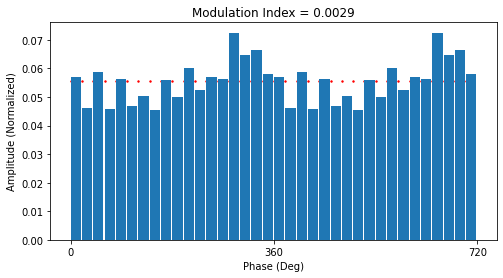

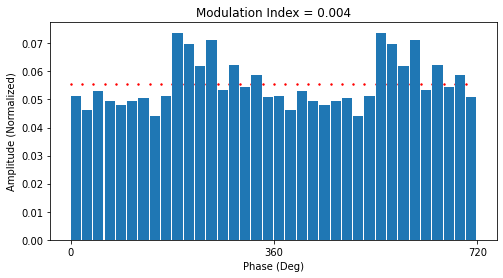

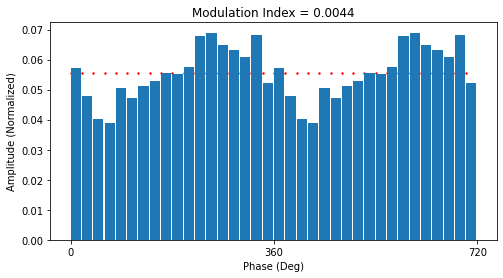

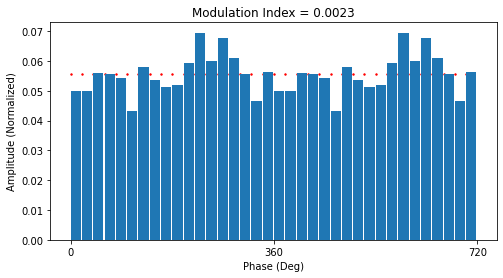

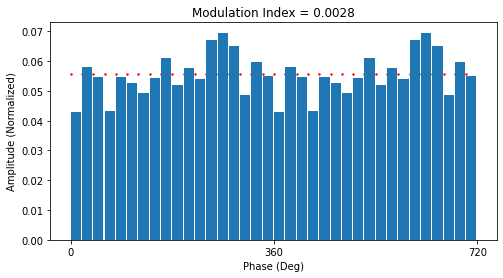

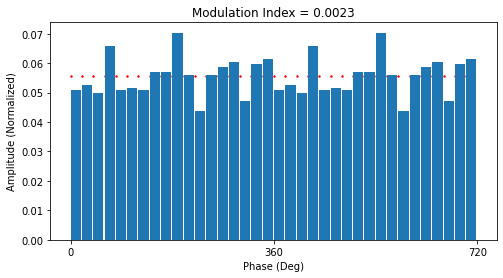

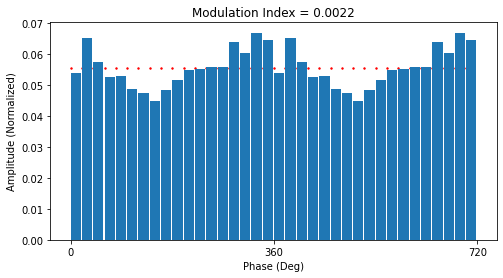

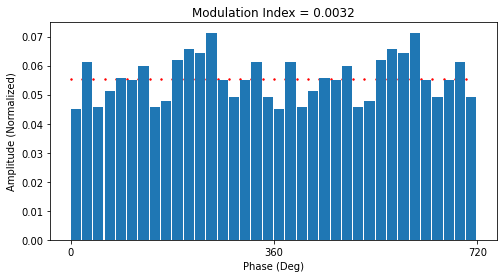

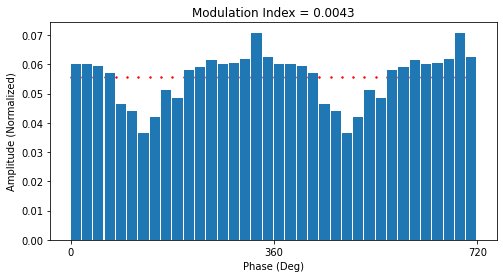

In [9]:
df = sp_phasing
for patient in patients:
    gh.Modulation_Index(df.set_index('patient').drop(columns = ['mi']).loc[patient,:].values, show = True)

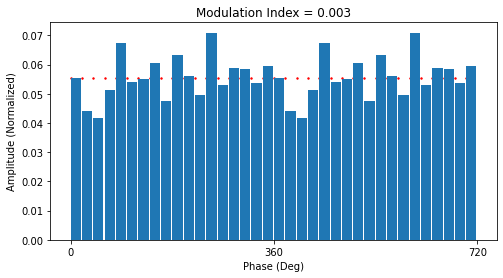

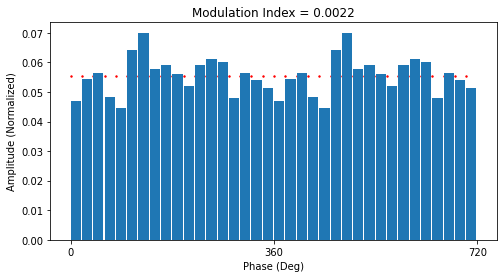

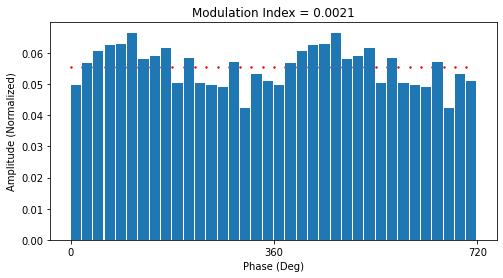

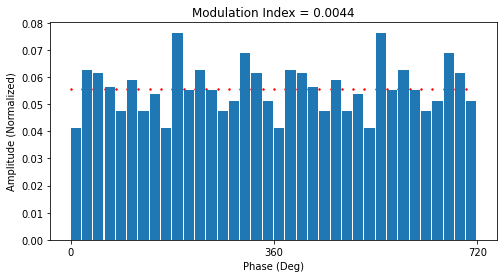

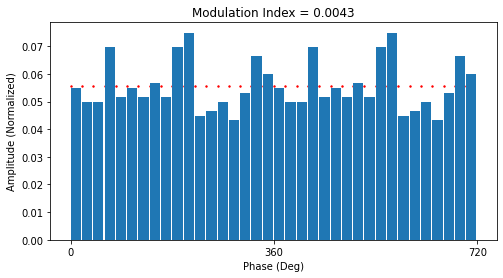

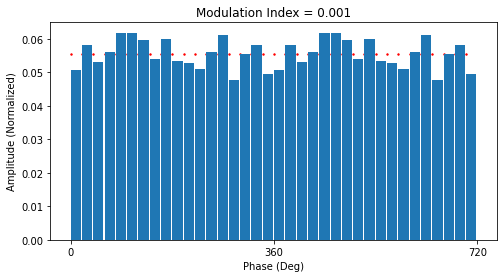

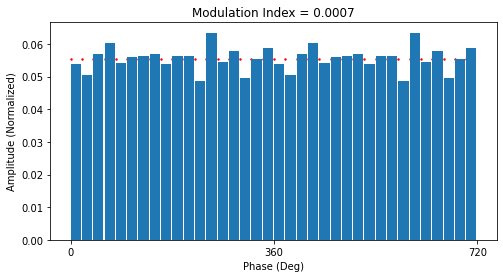

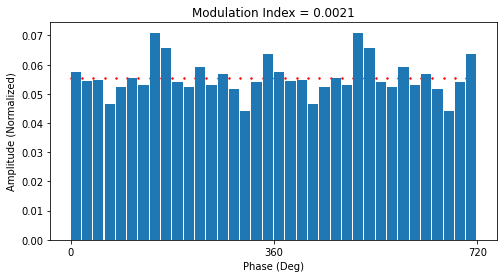

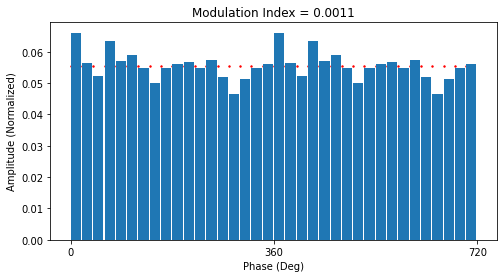

In [10]:
df = sw_phasing
for patient in patients:
    gh.Modulation_Index(df.set_index('patient').drop(columns = ['mi']).loc[patient,:].values, show = True)

/tmp/ipykernel_3414955/108609326.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  gh.Modulation_Index(sp_phasing.mean(), show = True)


0.016491243840595582

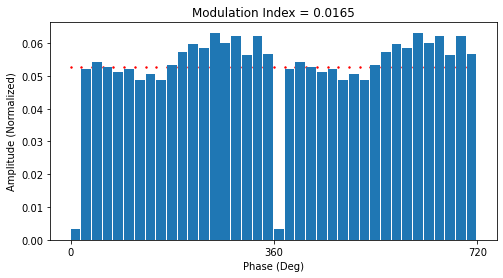

In [11]:
gh.Modulation_Index(sp_phasing.mean(), show = True)

/tmp/ipykernel_3414955/1583766394.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  gh.Modulation_Index(sw_phasing.mean(), show = True)


0.01615662674817723

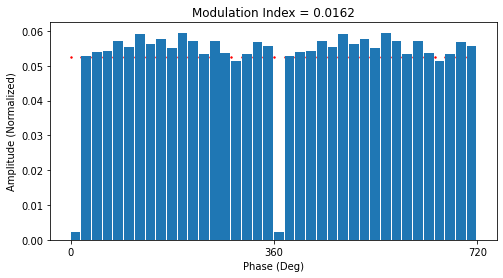

In [12]:
gh.Modulation_Index(sw_phasing.mean(), show = True)

In [13]:
sw_phasing['mi'].mean()

0.002321152559006827

In [14]:
save = False

concat_sp_phasing = []
concat_sw_phasing = []

nbins = 2

for patient in patients:
    print(patient)
    rsp = load_resp(patient)
    
    sp = load_sp(patient)
    concat_sp_phasing.append(count_events_phase_resp(nbins=nbins, patient=patient, events = sp['Peak'], rsp_events = rsp, save_rsp_encoded=save))
    
    sw = load_sw(patient)
    concat_sw_phasing.append(count_events_phase_resp(nbins=nbins, patient=patient, events = sw['Start'], rsp_events = rsp, save_rsp_encoded=False))
    
sp_phasing = pd.concat(concat_sp_phasing)
sw_phasing = pd.concat(concat_sw_phasing)

P1
P2
P3
P4
P5
P6
P7
P9
P10


In [15]:
sp_phasing_tidy = to_tidy(sp_phasing)

In [17]:
ttest = pg.ttest(x= sp_phasing_tidy[sp_phasing_tidy['phase']==1]['bin value'] , y=0.5)

In [18]:
ttest

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,7.5791,8,two-sided,0.000064,"[0.53, 0.55]",2.526367,408.625,0.999997


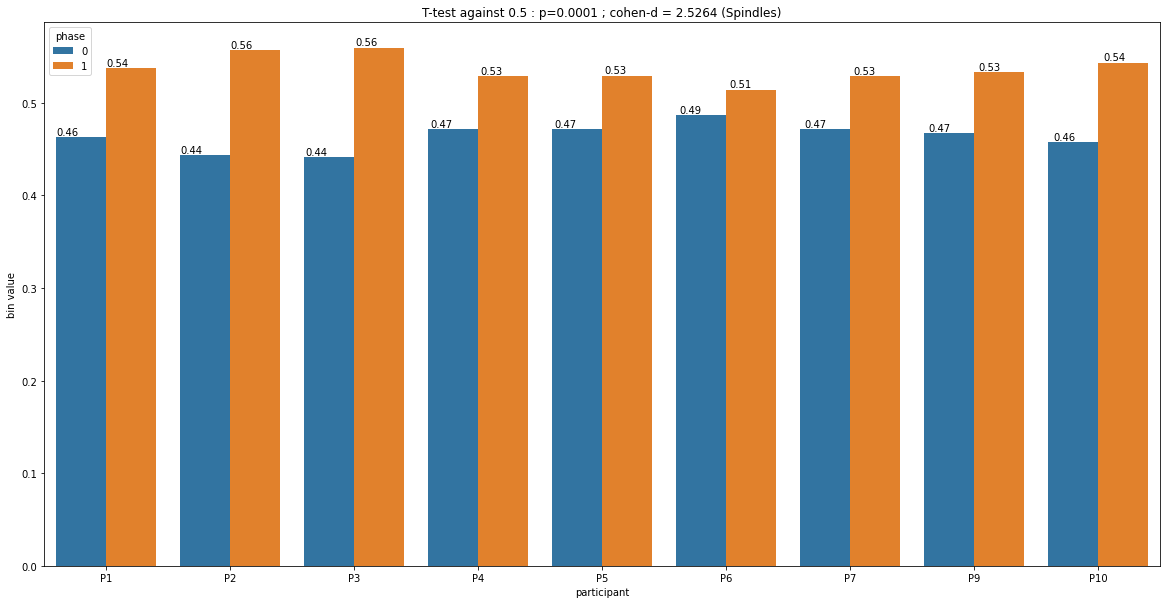

In [36]:
fig, ax = plt.subplots(figsize = (20,10))
sns.barplot(data =sp_phasing_tidy, x='patient', y ='bin value', hue = 'phase', ax=ax)
ax.set_xlabel('participant')
p = ttest.loc['T-test', 'p-val'].round(4)
cohen = ttest.loc['T-test', 'cohen-d'].round(4)
ax.set_title(f'T-test against 0.5 : p={p} ; cohen-d = {cohen} (Spindles)')
for p in ax.patches:
    ax.annotate(str(round(p.get_height(), 2)), (p.get_x() * 1.005, p.get_height() * 1.005))
# plt.savefig('../presentation_5/bar_2_bins_stats', bbox_inches='tight')

In [37]:
sw_phasing_tidy = to_tidy(sw_phasing)

In [38]:
ttest = pg.ttest(x= sw_phasing_tidy[sw_phasing_tidy['phase']==1]['bin value'] , y=0.5)

In [39]:
ttest

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-2.38743,8,two-sided,0.044032,"[0.48, 0.5]",0.79581,2.009,0.554786


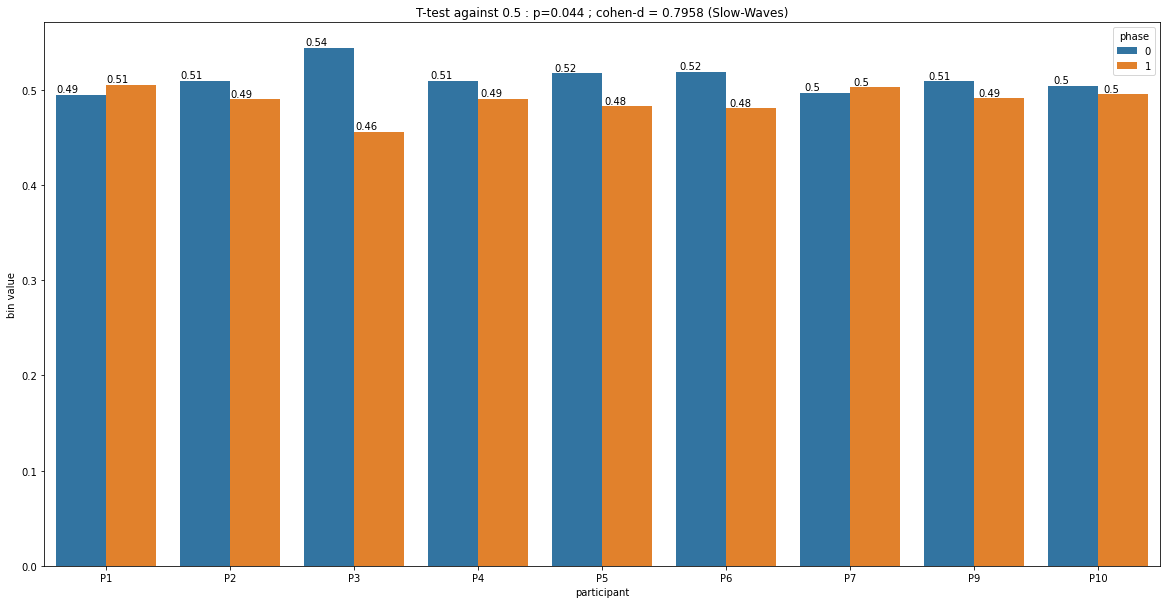

In [48]:
fig, ax = plt.subplots(figsize = (20,10))
sns.barplot(data =sw_phasing_tidy, x='patient', y ='bin value', hue = 'phase', ax=ax)
ax.set_xlabel('participant')
p = ttest.loc['T-test', 'p-val'].round(4)
cohen = ttest.loc['T-test', 'cohen-d'].round(4)
ax.set_title(f'T-test against 0.5 : p={p} ; cohen-d = {cohen} (Slow-Waves)')
for p in ax.patches:
    ax.annotate(str(round(p.get_height(), 2)), (p.get_x() * 1.005, p.get_height() * 1.005))
# plt.savefig('../presentation_5/bar_2_bins_stats_sw', bbox_inches='tight')

APPROCHE TIME

In [20]:
def get_timestamps(df_cycles, spindles_times, patient):
    rows = []

    for cycle in df_cycles.index: # loop only on cycles with spindles found inside

        start = df_cycles.loc[cycle,'inspi_time'] # get start time of the cycle
        transition = df_cycles.loc[cycle,'expi_time'] # get i-e time of the cycle
        stop = start + df_cycles.loc[cycle,'cycle_duration'] # get stop time of the cycle
        duration = df_cycles.loc[cycle,'cycle_duration']
        inspi_duration = transition - start
        expi_duration = stop - transition

        spindles_of_the_cycle = spindles_times[(spindles_times >= start) & (spindles_times <= stop)].values # keep the spindles of the cycle

        for spindle_time in spindles_of_the_cycle: # loop on spindles of the cycle
            time_post_start = spindle_time - start
            time_vs_transition = spindle_time - transition
            time_pre_end = stop - spindle_time

            norm_time = (spindle_time - start) / duration

            rows.append([patient, cycle, start, transition, stop, inspi_duration, expi_duration, duration, spindle_time, time_post_start, time_vs_transition, time_pre_end, norm_time])
    df_times = pd.DataFrame(rows, columns = ['patient','cycle','start cycle', 'transition ie', 'stop cycle', 'inspi duration','expi duration','cycle duration','spindle time', 'time post start', 'time vs transition ie','time pre end','norm time'])
    return df_times

In [41]:
concat_df_times = []

for patient in patients:
    df_cycles, spindles_times = load_resp(patient), load_sw(patient)['NegPeak']
    concat_df_times.append(get_timestamps(df_cycles, spindles_times, patient))
    
df_times_all = pd.concat(concat_df_times)

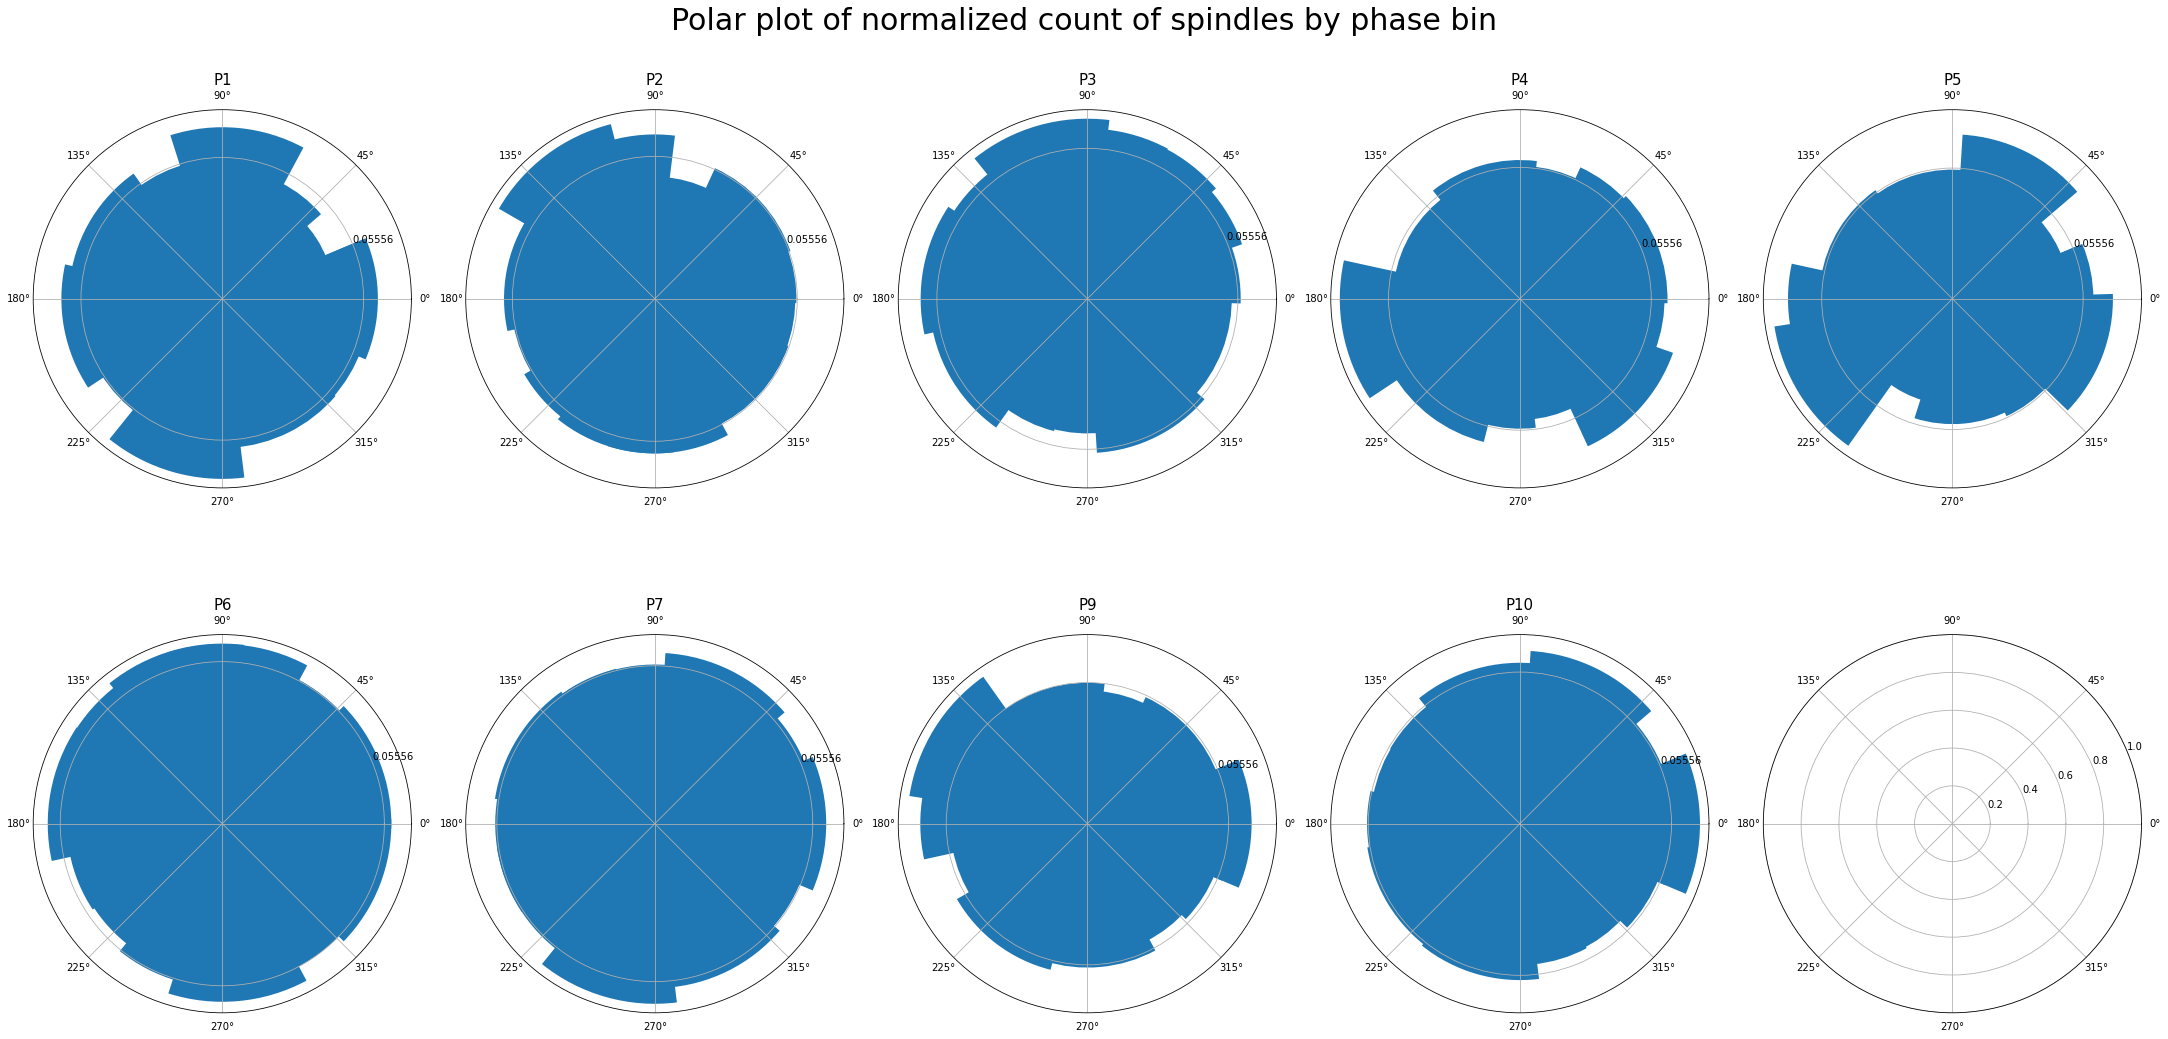

In [46]:
fig, axs = plt.subplots(nrows = 2, ncols = 5, subplot_kw=dict(projection = 'polar'), figsize = (30,15), constrained_layout = True)
fig.suptitle('Polar plot of normalized count of spindles by phase bin', fontsize = 30)
bins = 18
for row, sublist in enumerate([ patients[:5], patients[5:]]):
    for col, patient in enumerate(sublist):
        ax = axs[row, col]
        hist , values = np.histogram(df_times_all[df_times_all['patient'] == patient]['norm time'], bins = bins, density = True)
        ax.bar(np.linspace(0,2*np.pi,bins), hist / sum(hist))
        ax.set_rticks([1/bins])
        ax.set_title(f'{patient}', fontsize = 15, y = 1.05)
# plt.savefig('../presentation_5/detailed_polar_plot')

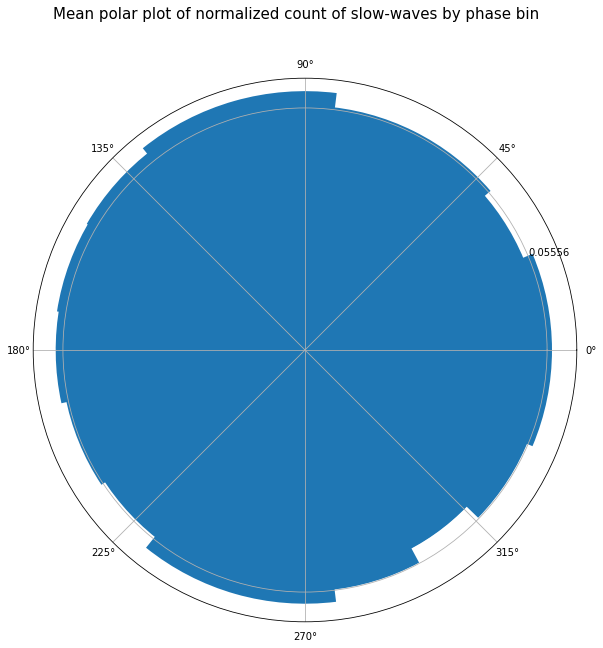

In [44]:
fig, ax = plt.subplots(subplot_kw=dict(projection = 'polar'), figsize = (10,10))
fig.suptitle('Mean polar plot of normalized count of spindles by phase bin', fontsize = 15)
bins = 18
hist , values = np.histogram(df_times_all['norm time'], bins = bins, density = False)
ax.bar(np.linspace(0,2*np.pi,bins), hist / sum(hist))
# ax.set_rmax(0.08)
ax.set_rticks([1/bins])
# plt.savefig('../presentation_5/mean_polar_plot')

<AxesSubplot:ylabel='Frequency'>

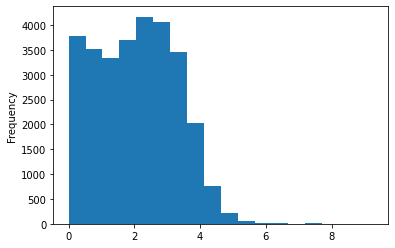

In [27]:
df_times_all['time post start'].plot.hist(bins = 18)

<AxesSubplot:ylabel='Frequency'>

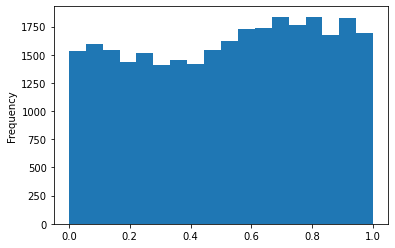

In [28]:
df_times_all['norm time'].plot.hist(bins=18)

<AxesSubplot:ylabel='Frequency'>

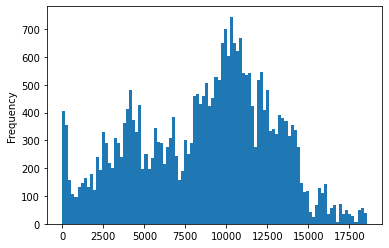

In [29]:
df_times_all['spindle time'].plot.hist(bins = 100)

<AxesSubplot:ylabel='Frequency'>

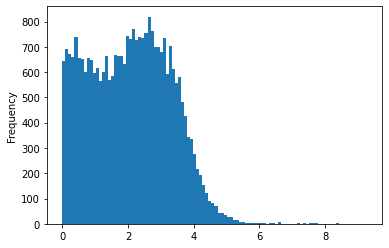

In [30]:
df_times_all['time post start'].plot.hist(bins = 100)

<AxesSubplot:ylabel='Frequency'>

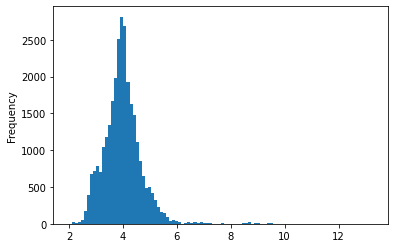

In [31]:
df_times_all['cycle duration'].plot.hist(bins = 100)

<AxesSubplot:ylabel='Frequency'>

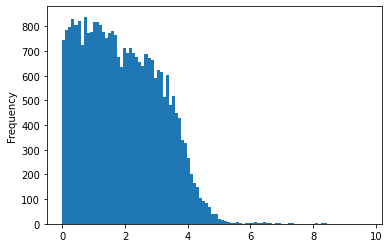

In [32]:
df_times_all['time pre end'].plot.hist(bins = 100)

In [33]:
def get_event_plot_patient(df, patient, ax=None, colname = 'norm time'):
    df_patient =  df[(df['patient'] == patient)][['cycle',colname,'cycle duration']].sort_values(by = 'cycle duration')
    rows = []
    for c in df_patient['cycle'].unique():
        row = df_patient[df_patient['cycle'] == c]
        rows.append(list(row[colname].values) )
        
    if ax is None:
        fig, ax = plt.subplots()
    ax.eventplot(rows,linelengths=10, linewidth = 2, colors = 'black')
    return ax

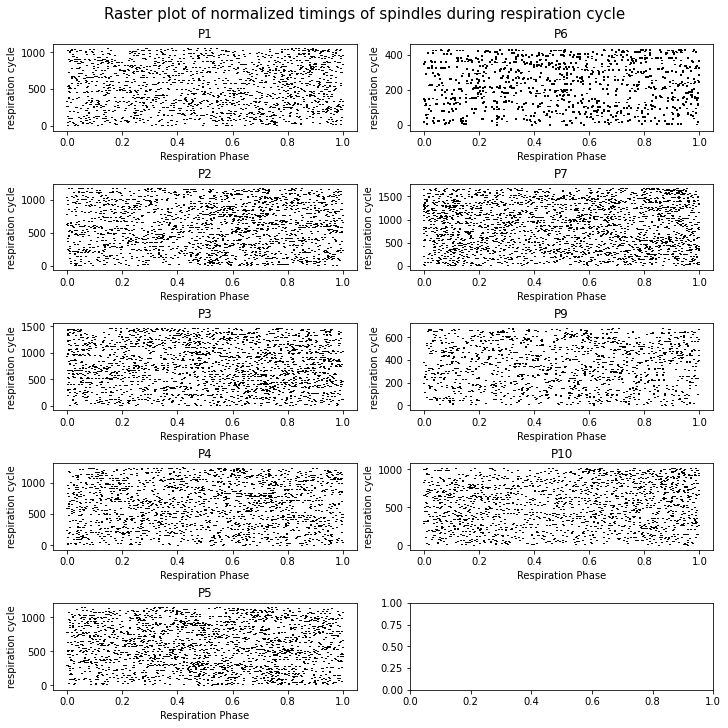

In [34]:
fig, axs = plt.subplots(ncols = 2, nrows = 5, figsize = (10,10), constrained_layout = True)
fig.suptitle('Raster plot of normalized timings of spindles during respiration cycle', fontsize = 15)
for col, semi_list in enumerate([patients[:5],patients[5:]]):
    for row, patient in enumerate(semi_list):
        ax = axs[row, col]
        ax = get_event_plot_patient(df=df_times_all, patient=patient, ax=ax, colname = 'norm time')
        ax.set_title(patient)
        ax.set_ylabel('respiration cycle')
        ax.set_xlabel('Respiration Phase')
# plt.savefig('../presentation_4/raster_plot_normalized')
plt.show()

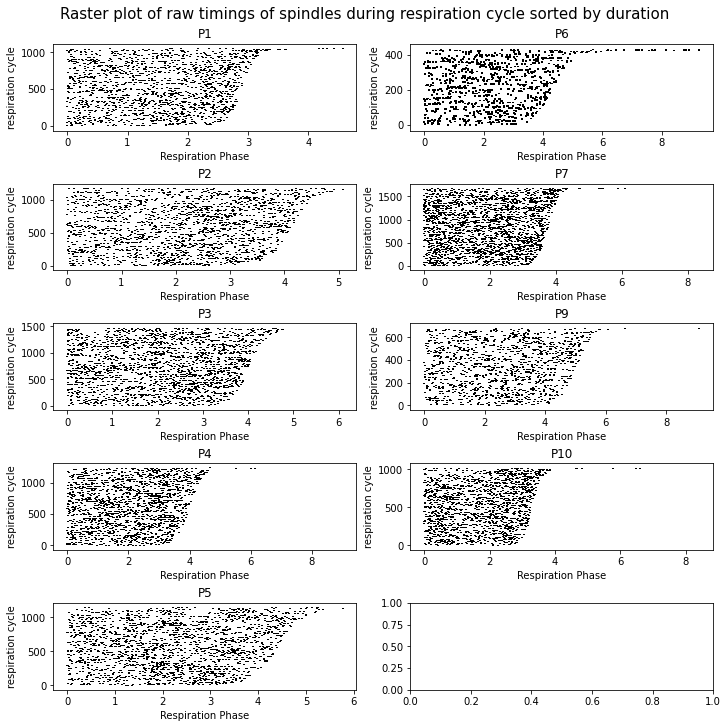

In [35]:
fig, axs = plt.subplots(ncols = 2, nrows = 5, figsize = (10,10), constrained_layout = True)
fig.suptitle('Raster plot of raw timings of spindles during respiration cycle sorted by duration', fontsize = 15)
for col, semi_list in enumerate([patients[:5],patients[5:]]):
    for row, patient in enumerate(semi_list):
        ax = axs[row, col]
        ax = get_event_plot_patient(df=df_times_all, patient=patient, ax=ax, colname = 'time post start')
        ax.set_title(patient)
        ax.set_ylabel('respiration cycle')
        ax.set_xlabel('Respiration Phase')
# plt.savefig('../presentation_4/raster_plot_sorted')
plt.show()